# The Business-Case Introduction

## What is this business-case going to answer and where?

### The place:
Brooklyn, a USA Borough, in NEW York City.

### The problem:
A stakeholder has restaurant in Brooklyn, he wants to expand his business by opening a new branch in the same borough. Where would he be recommended to open? 
The stakeholder asked me to help him in finding the best place to open his new branch.

The stakeholder made an initial investigation and provide me with 5 places in Broklyn to state his business
![which place](https://alexmedia.co/brooklyn.jpg)
The current place appears in red, while the investigated places appear in blue

### The Dataset:
As a data analyst I got New York data from NYU spatial data repository and find that it has 5 boroughs:

* Manhattan with 40 neighbors
* Bronx with 52 neighbors
* Staten with Island 63 neighbors
* Brooklyn with 70 neighbors
* Queens with 81 neighbors


### The Methodology:
I planned my task as following by dividing  it into two main methods:
1. Get the top 100 venues that are in each distinct within a radius of 500 meters
2. Group venues by neighborhood and by taking the mean of the frequency of occurrence of each category
3. Retrieve each neighborhood along with the top 10 most common venues
4. Run k-means to cluster the neighborhood into 5 clusters.
5. make our decision based on generated clusters

## The Process:
We are going to work on "New York" state in USA
* First we will extract all Newyork neighbors usind data provided by NYU spatial data repository at https://geo.nyu.edu 
* Second, We will use Foursquare API  provided by https://developer.foursquare.com/ to retrieve all needed location, Borough, Categories, Rating, and Trending information
this is the main data we will use for cleaning, wrangling and put for further investigations

* Thirdly, We will use skilearn library from python to analysis our data using proper machine learning algorithms. here we will use K-means, an algorithm best suits our case analysis and investigations.

* Then we will use matplotlib library to visualize the investigated results on maps using Foluim library for python

* Finally, we will put it all together in a simple way, such that stackholders can make their decision easily based on our data analysis investigation for this business case.

# Data Insight and Prepration

In [1]:
# import pandas library to work with dataframe
import pandas as pd
import numpy as np
import matplotlib as mat

In [2]:
# @hidden_cell
CLIENT_ID = '2UABPTQXVSFUWXVMSQYXON4FACFMLWPELLQFVBYK3S0TLBNV' # your Foursquare ID
CLIENT_SECRET = 'AFKQI22J5NIJ1JSMPU0ZJ2TGHMPAIT04BAPUUD1MOAOIYVLE' # your Foursquare Secret
VERSION = '20180604'

In [3]:
#!conda install -c conda-forge geopy --yes 
!pip install geopy 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests # library to handle requests

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
!pip install folium
import folium # plotting library

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


In [4]:
# Function for creating map of any borough using latitude and longitude values
def print_map (my_data, zoom=11):
    my_map = folium.Map(location=[latitude, longitude], zoom_start=zoom)
    for lat, lng, label in zip(my_data['Latitude'], my_data['Longitude'], my_data['Neighborhood']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(my_map)
    return my_map

In [5]:
!wget -q -O 'newyork_data.json' https://geo.nyu.edu/download/file/nyu-2451-34572-geojson.json
print('Data downloaded!')

Data downloaded!


In [6]:
with open('newyork_data.json') as json_data:
    df_newyork = json.load(json_data)

In [7]:
df_newyork = df_newyork['features']

In [8]:
#let us have a look
df_newyork[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [9]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork_data = pd.DataFrame(columns=column_names)

In [10]:
len(df_newyork)

306

In [11]:
# let us populate it
for data in df_newyork:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_data = newyork_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [12]:
newyork_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [13]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(newyork_data['Borough'].unique()),
        newyork_data.shape[0]
    )
)

#how many neighborhood each borough has
df_groups = newyork_data.groupby (['Borough']).count()
df_groups

The dataframe has 5 boroughs and 306 neighborhoods.


,Neighborhood,Latitude,Longitude
Borough,,,
Bronx,52,52,52
Brooklyn,70,70,70
Manhattan,40,40,40
Queens,81,81,81
Staten Island,63,63,63


In [14]:
# Use geopy library to get the latitude and longitude values of New York City.
address = 'New York City, NY'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of New York City are 40.7308619, -73.9871558.


In [15]:
# create map of New York using latitude and longitude values
print_map (newyork_data, zoom=10)

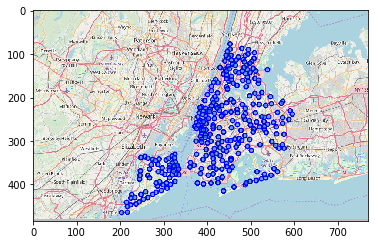

In [16]:
# a little tweak to show maps as images in github
plt.imshow(mpimg.imread('newyork.jpg'))

In [18]:
brooklyn_data = newyork_data[newyork_data['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [19]:
# create map of Manhattan using latitude and longitude values  
print_map (brooklyn_data, zoom=10)    


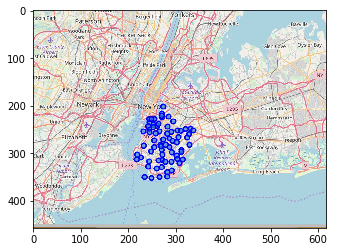

In [20]:
# a little tweak to show maps as images in github
plt.imshow(mpimg.imread('brooklyn.jpg'))


# Let us start  analyzing the data

In [21]:
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [22]:
neighborhood_latitude = brooklyn_data.loc[3, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = brooklyn_data.loc[3, 'Longitude'] # neighborhood longitude value

neighborhood_name = brooklyn_data.loc[3, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Greenpoint are 40.7302009848647, -73.95424093127393.


In [24]:
# Now, let's get the top 100 venues that are in Greenpoint within a radius of 500 meters.
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL



'https://api.foursquare.com/v2/venues/explore?&client_id=2UABPTQXVSFUWXVMSQYXON4FACFMLWPELLQFVBYK3S0TLBNV&client_secret=AFKQI22J5NIJ1JSMPU0ZJ2TGHMPAIT04BAPUUD1MOAOIYVLE&v=20180604&ll=40.7302009848647,-73.95424093127393&radius=500&limit=100'

In [25]:
results = requests.get(url).json()


In [26]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [27]:
# Now we are ready to clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,goodyoga,Yoga Studio,40.730010,-73.956167
1,Sunshine Laundry & Pinball Emporium,Laundry Service,40.729318,-73.953564
2,Karczma,Polish Restaurant,40.730102,-73.955092
3,Oxomoco,Mexican Restaurant,40.729981,-73.955460
4,Black Rabbit,Bar,40.730057,-73.956588


In [28]:
# Let's create a function to repeat the same process to all the neighborhoods in that Borough 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )




Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [31]:
print(brooklyn_venues.shape)
brooklyn_venues.head()

(2806, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
2,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place


In [32]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]
print (brooklyn_onehot.shape)
brooklyn_onehot.head()

(2806, 289)


,Yoga Studio,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,

In [33]:
# Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
print (brooklyn_grouped.shape)
brooklyn_grouped

(70, 289)


,Neighborhood,Yoga Studio,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,

In [35]:
# Let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5
for hood in brooklyn_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = brooklyn_grouped[brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
   # print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [36]:
# Let's put that into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
# Now let's create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Chinese Restaurant,Pizza Place,Pharmacy,Donut Shop,Fast Food Restaurant,Sushi Restaurant,Shoe Store,Women's Store,Mobile Phone Shop,Italian Restaurant
1,Bay Ridge,Italian Restaurant,Pizza Place,Spa,Bar,American Restaurant,Bagel Shop,Greek Restaurant,Thai Restaurant,Grocery Store,Sushi Restaurant
2,Bedford Stuyvesant,Coffee Shop,Pizza Place,Café,Bar,Bus Stop,Juice Bar,Wine Bar,Gourmet Shop,Basketball Court,Boutique
3,Bensonhurst,Chinese Restaurant,Ice Cream Shop,Pizza Place,Sushi Restaurant,Hotpot Restaurant,Supermarket,Coffee Shop,Grocery Store,Noodle House,Liquor Store
4,Bergen Beach,Harbor / Marina,Hockey Field,Baseball Field,Donut Shop,Playground,Park,Athletics & Sports,Women's Store,Filipino Restaurant,Fish & Chips Shop
5,Boerum Hill,Coffee Shop,Bar,Dance Studio,French Restaurant,Spa,Bakery,Grocery Store,Kids Store,Furniture / Home Store,Martial Arts Dojo
6,Borough Park,Pizza Place,Deli / Bodega,Bank,Fast Food Restaurant,Café,Pharmacy,American Restaurant,Coffee Shop,Hotel,Restaurant
7,Brighton Beach,Beach,Eastern European Restaurant,Restaurant,Fast Food Restaurant,Russian Restaurant,Sushi Restaurant,Gourmet Shop,Bank,Mobile Phone Shop,Pharmacy
8,Broadway Junction,Donut Shop,Diner,Dessert Shop,Burger Joint,Ice Cream Shop,Metro Station,Moving Target,Fried Chicken Joint,Dry Cleaner,Deli / Bodega
9,Brooklyn Heights,Yoga Studio,Park,Italian Restaurant,Deli / Bodega,Gym,Cosmetics Shop,Wine Shop,Pet Store,Bar,Mexican Restaurant


In [38]:
# set number of clusters
kclusters = 5

brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 2, 0, 0, 2, 0, 4, 0], dtype=int32)

In [39]:
# Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
brooklyn_merged = brooklyn_data

# add clustering labels
brooklyn_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
brooklyn_merged = brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

brooklyn_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,2,Italian Restaurant,Pizza Place,Spa,Bar,American Restaurant,Bagel Shop,Greek Restaurant,Thai Restaurant,Grocery Store,Sushi Restaurant
1,Brooklyn,Bensonhurst,40.611009,-73.995180,0,Chinese Restaurant,Ice Cream Shop,Pizza Place,Sushi Restaurant,Hotpot Restaurant,Supermarket,Coffee Shop,Grocery Store,Noodle House,Liquor Store
2,Brooklyn,Sunset Park,40.645103,-74.010316,0,Bank,Mexican Restaurant,Pizza Place,Latin American Restaurant,Bakery,Mobile Phone Shop,Pharmacy,Gym,Grocery Store,Donut Shop
3,Brooklyn,Greenpoint,40.730201,-73.954241,2,Bar,Pizza Place,Coffee Shop,Café,Cocktail Bar,Yoga Studio,Record Shop,Bakery,Mexican Restaurant,French Restaurant
4,Brooklyn,Gravesend,40.595260,-73.973471,0,Pizza Place,Bus Station,Bakery,Lounge,Italian Restaurant,Chinese Restaurant,Diner,Martial Arts Dojo,Breakfast Spot,Metro Station


# The Results

In [40]:
# Finally, let's visualize the resulting clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

![which place](https://alexmedia.co/places.jpg)

# Which One and Why (The Conclusion )
![which place](https://alexmedia.co/brooklyn2.jpg)
My choice is to open the new branch at the surrounded place in black, because it has the most similarity with the stackholder first branch as they are both placed in the same cluster
The tow places appear in the original map in mauve color

In [42]:
!ipython nbconvert --to html notebook.html

[TerminalIPythonApp] WARNING | Subcommand `ipython nbconvert` is deprecated and will be removed in future versions.
[TerminalIPythonApp] WARNING | You likely want to use `jupyter nbconvert` in the future
[NbConvertApp] WARNING | pattern 'notebook.html' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--debug
    set log level to logging.DEBUG (maximize logging output)
--generate-config
    generate default config file
-y
    Answer yes to any questions instead of prompting.
--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only rel

In [44]:
!jupyter nbconvert labs/DP0701EN/Final-Project-Copy1.ipynb --to slides --post serve

[NbConvertApp] WARNING | pattern 'labs/DP0701EN/Final-Project-Copy1.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--debug
    set log level to logging.DEBUG (maximize logging output)
--generate-config
    generate default config file
-y
    Answer yes to any questions instead of prompting.
--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--stdout
    Write no

In [45]:
!jupyter nbconvert Final-Project-Copy1.ipynb --to pdf

[NbConvertApp] Converting notebook Final-Project-Copy1.ipynb to pdf
[NbConvertApp] Support files will be in Final-Project-Copy1_files/
[NbConvertApp] Making directory ./Final-Project-Copy1_files
[NbConvertApp] Making directory ./Final-Project-Copy1_files
[NbConvertApp] Writing 532446 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex']
[NbConvertApp] CRITICAL | xelatex failed: ['xelatex', './notebook.tex']
This is XeTeX, Version 3.14159265-2.6-0.99992 (TeX Live 2015/dev/Debian) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(./notebook.tex
LaTeX2e <2014/05/01>
Babel <3.9l> and hyphenation patterns for 2 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size11.clo))
(/usr/share/texlive/texmf-dist/tex/latex/base/fontenc.sty
(/usr/share/texlive/tex

In [ ]:
!jupyter nbconvert Final-Project-Copy1.ipynb --to pdf